In [2]:
import sys
sys.path.append('/home/jupyter/cloud_pint')

In [ ]:

import pandas as pd
import numpy as np
from pathlib import Path
from src.utils.smoothing_methods import SmoothingMethods
from src.utils.data_loader import load_processed_data
from scipy import stats
import matplotlib.pyplot as plt
from scipy import signal
from src.preprocessing.curve_fit_clustering import min_max_scale_data_by_group
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder



In [44]:
import scipy.stats as stats
import time
import seaborn as sns
from pprint import pprint

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.svm import LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor


SEED = 9

## you can make this 'True' but for now, I turned it off
## You'll need to have a play and tune it
RF_HYPERPARAM_TUNING = False


def logged_box_plot(df, my_title):
    fig, ax = plt.subplots(figsize=(12, 6))
    g = sns.boxplot(data=df,linewidth=2.5,ax=ax)
    g.set_title(my_title)
    return g.set_yscale("log")
    

def get_corr(df, x_col, y_cols):
    '''
    Simple linear regression with r2 and p-value
    '''
    for y_col in y_cols:
        x = df[x_col]
        y = df[y_col]
          
        g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
        r, p = stats.pearsonr(x, y)
        print(f"{x_col} vs {y_col}: The Rho is {'{:.3}'.format(r)} and p={'{:.3}'.format(p)}")
    
        g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                            xy=(0.1, 0.9), xycoords='axes fraction',
                            ha='left', va='center',
                            bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
        g.ax_joint.scatter(x, y)
        g.set_axis_labels(xlabel=x_col, ylabel=y_col, size=15)
        plt.tight_layout()


def eval_models(model, y_test, y_pred, print_scores=False):
    '''
    root mean squared error (how much model's predictions differ from the actual labels)
    '''
    r2_score = metrics.r2_score(y_test, y_pred)
    MAE = metrics.mean_absolute_error(y_test, y_pred)
    MSE = metrics.mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    
    if print_scores:
        print("R-squared: {:.3f}".format(r2_score))
        print("Mean Absolute Error: {:.3f}".format(MAE))
        print("Mean Squared Error: {:.3f}".format(MSE))
        print("Root Mean Squared Error: {:.3f}".format(RMSE))
    return r2_score, MAE, MSE, RMSE


def compute_vif(considered_features):
    '''
    compute the variance inflation factor (vif) for all given features
    (metric for gauging multicollinearity)
    The VIF directly measures the ratio of the variance of the entire model 
    to the variance of a model with only the feature in question.
    (how much a feature’s inclusion contributes to the overall variance of 
     the coefficients of the features in the model.)
    
    A VIF of 1 indicates that the feature has no correlation with any of the other features.
    A VIF value exceeding 5 or 10 is deemed to be too high. 
    Any feature with such VIF values is likely to be contributing to multicollinearity.

    '''
    X = df[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

 
def select_features(X_train, y_train, X_test, score_func):
   	# configure to select all features
   	fs = SelectKBest(score_func=score_func, k='all')
   	# learn relationship from training data
   	fs.fit(X_train, y_train)
   	# transform train input data
   	X_train_fs = fs.transform(X_train)
   	# transform test input data
   	X_test_fs = fs.transform(X_test)
   	return X_train_fs, X_test_fs, fs


def plot_actual_vs_predicted_value(index, y_pred, y_test, my_title):
    # test = pd.DataFrame({'Predicted value':y_pred, 'Actual value':y_test})
    plt.figure(figsize=(12,6))
    # test = test.reset_index(drop=True)
    # test = test.drop(['No'],axis=1)
    # plt.plot(test)
    plt.plot(index, y_test)
    plt.plot(index, y_pred)
    plt.title(my_title)

    
    plt.legend(['Actual value','Predicted value'])
    
    
def plot_feature_importance(regressor, regressor_key):
    plt.figure(figsize=(12,6))
    importance_model = pd.Series(regressor.feature_importances_, index=X.columns).sort_values()
    importance_model.plot(kind='barh', color='cornflowerblue')
    plt.title(f'Feature Importance: {regressor_key}')
    
    

In [4]:
smoother = SmoothingMethods()

# Define a function to interpolate outliers
def interpolate_outliers(series, threshold=3, method='linear'):
    z_scores = np.abs((series - series.mean()) / series.std())
    outliers = z_scores > threshold
    plt.figure()
    plt.plot(series, label='Original Data')
    num_outliers_removed = sum(outliers)
    series[outliers] = np.nan
    series.interpolate(method=method, inplace=True)
    plt.plot(series, label='Interpolated Data')
    plt.title(f'Number of Outliers Removed: {num_outliers_removed}')
    plt.legend()  # Add legend to the plot
    return series, num_outliers_removed


def calculate_correlations_and_plot(group, bp_signal, neural_signal, show_plot=True):
    # Initialize lists to store correlations and group names
    correlations = []
    group_names = []


    # Iterate over groups and calculate correlations
    for group_name, grouped in group:
        bladder_pressure = grouped[bp_signal].values
        cross_correlation = grouped[neural_signal].values
        correlation, pval = stats.pearsonr(bladder_pressure, cross_correlation)
        correlations.append(correlation)
        group_names.append(group_name)
        
        if show_plot:
            # Create plots
            fig, ax = plt.subplots()
            # ax.plot(bladder_pressure, "r")
            ax.scatter(grouped.index, bladder_pressure, color='r', label=f'{bladder_pressure}', s=5, alpha=0.3)
            ax2 = ax.twinx()
            # ax2.plot(cross_correlation)
            ax2.scatter(grouped.index, cross_correlation,  color='b', label=f'{cross_correlation}', s=5, alpha=0.3)
            ax.annotate(f'Correlation: {correlation:.2f}; P-value: {pval:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10)
            plt.title(f'Group {group_name}')


    # Create a new DataFrame to store results
    result_df = pd.DataFrame({'Group': group_names, 'Correlation': correlations})

    # Return the DataFrame
    return result_df




def calculate_correlations_and_plot_all_together(df, sig_method_col, bp_col, min_max_scale=False, show_plot=False, void_or_bl='void'):
    # import pdb; pdb.set_trace()
    # Select the relevant columns without NaN values
    df_nonna = df[~df[sig_method_col].isna()]
    if void_or_bl == 'void':
        df_nonna = df_nonna[~df_nonna['optimal_inflection'].isna()]
    
    bp_sig = df_nonna[bp_col].values
    method_sig = df_nonna[sig_method_col].values
    
    # Calculate and print the Pearson correlation coefficient
    correlation, pval = stats.pearsonr(method_sig, bp_sig)
    print(f'\n{sig_method_col} vs {bp_col}')
    print(f"Pearson Corr Coeff: {correlation:.2f}")
    print(f"Pearson Corr P: {pval:.4f}")
    
    df_nonna_temp = min_max_scale_data_by_group(df_nonna.copy(), group_var='troughs_group', 
                                      in_var=bp_col, 
                                      out_var=f'{bp_col}_scaled', 
                                      desired_min=0, desired_max=1)
    
    df_nonna_temp = min_max_scale_data_by_group(df_nonna_temp.copy(), group_var='troughs_group', 
                                      in_var=sig_method_col, 
                                      out_var=f'{sig_method_col}_scaled', 
                                      desired_min=0, desired_max=1)
        
    bp_sig_scaled = df_nonna_temp[f'{bp_col}_scaled'].values
    method_sig_scaled = df_nonna_temp[f'{sig_method_col}_scaled'].values
    
    
    if show_plot:
        if min_max_scale:
            fig, ax = plt.subplots(figsize=(16,6))
            ax.scatter(df_nonna_temp.index, method_sig_scaled, color='r', s=5, alpha=0.5, label='sig_method_col')
            ax2 = ax.twinx()
            ax2.scatter(df_nonna_temp.index, bp_sig_scaled, color='b', s=5, alpha=0.3, label='bp_col')
            plt.title(f'{sig_method_col} vs {bp_col}')


            if void_or_bl == 'void':
                for i, cp in enumerate(df_nonna_temp[df_nonna_temp['optimal_inflection']].index):
                    plt.text(cp, plt.ylim()[1], str(i), va='bottom', ha='center', color='black', fontsize=8, alpha=0.5)
            
        else:
            # plt.plot(df_nonna.index, method_sig_scaled, color='r', label=f'{sig_method_col}_scaled')
            # plt.plot(df_nonna.index, bp_sig_scaled, color='b', label=f'{bp_col}_scaled')

        # Create a plot with two y-axes
        # fig, ax = plt.subplots(figsize=(16,6))
        # ax.plot(method_sig, "b", alpha=0.5)
        # ax2 = ax.twinx()
        # ax2.plot(bp_sig, "r", alpha=0.5)
        # ax.plot(bladder_pressure, "r")
        # ax2.plot(cross_correlation)

            fig, ax = plt.subplots(figsize=(16,6))
            ax.scatter(df_nonna.index, method_sig, color='r', s=5, alpha=0.5, label='sig_method_col')
            ax2 = ax.twinx()
            ax2.scatter(df_nonna.index, bp_sig, color='b', s=5, alpha=0.3, label='bp_col')
            plt.title(f'{sig_method_col} vs {bp_col}')
            
            if void_or_bl == 'void':
                for i, cp in enumerate(df_nonna[df_nonna['optimal_inflection']].index):
                    plt.text(cp, plt.ylim()[1], str(i), va='bottom', ha='center', color='black', fontsize=8, alpha=0.5)
            
        
        # Combine the legends
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, loc='upper right')
        
        # Add the correlation value as a text annotation on the plot
        ax.annotate(f'Correlation: {correlation:.2f}; P-value: {pval:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10)
       
    return correlation, pval



    

def load_and_patch_data(data_drive, base_dir, file_exception_wildcard, processed_folder_name_cc, processed_folder_name_void):
    # import pdb; pdb.set_trace()
    # Load neural data
    df_neural = load_processed_data(data_drive, base_dir, processed_folder_name_cc, file_exception_wildcard)
    all_df_cols = [GROUP_VAR_ALL, BP_SIGNAL, 'time', 'sf']
    
    df_neural_void = df_neural[~df_neural[GROUP_VAR_ALL].str.contains('0.1')].reset_index(drop=True)
    df_neural_bl = df_neural[df_neural[GROUP_VAR_ALL].str.contains('0.1')].reset_index(drop=True)
    
    # Load bladder pressure data
    df_bp_void = pd.read_csv(base_dir.joinpath('BladderPressure', 'bp_void.csv'), low_memory=False, index_col=0)
    df_bp_bl = pd.read_csv(base_dir.joinpath('BladderPressure', 'bp_baseline.csv'), low_memory=False, index_col=0)
    
    # Merge dataframes
    df_void = pd.concat([df_bp_void.drop(columns=all_df_cols), df_neural_void], axis=1)
    df_bl = pd.concat([df_bp_bl.drop(columns=all_df_cols), df_neural_bl], axis=1)
    df = pd.concat([df_void, df_bl], axis=0).reset_index(drop=True)
    
    return df_void, df_bl, df


def run_james_method(df, neural_signal, bp_signal, void_or_bl):
    # import pdb; pdb.set_trace()
    # subject_specific_flip = df_void.groupby('source')['flip_signal_subject'].value_counts()
    # file_specific_flip = df_void.groupby('source')['flip_signal_file'].value_counts()
    # df_flip = pd.merge(subject_specific_flip, file_specific_flip, left_index=True, right_index=True)
    
    df[neural_signal] = np.where(df['flip_signal_file'], df[neural_signal]*-1, df[neural_signal])
    
    
    # df_void.groupby('source')['file_signal_quality_ma'].unique()
    
    # =============================================================================
    # cheating way to clean bp data???
    # =============================================================================
    
    # df[neural_signal], num_outliers_removed  = interpolate_outliers(df[neural_signal].copy(), threshold=10)
    # df[neural_signal], num_outliers_removed  = interpolate_outliers(df[neural_signal].copy(), threshold=10)
    
    df[f'medfilt_{neural_signal}'] = df.groupby('source')[neural_signal].transform(signal.medfilt, 3)
    plt.figure()
    plt.plot(df[neural_signal])
    neural_signal = f'medfilt_{neural_signal}'
    plt.plot(df[neural_signal])
    
    
    # ## flipping for james -- not working
    # flip_for_james = df_void.groupby('troughs_group')[NEURAL_SIGNAL].last()<0
    # df_void['flip_for_james'] = df_void['troughs_group'].map(flip_for_james)
    # df_void['flip_for_james'] = df_void['flip_for_james'].fillna(False)
    
    
    # df_void.groupby('troughs_group')[neural_signal].last()

    # =============================================================================
    # signal methods
    # =============================================================================
    cumsum = lambda x: smoother.cumulative_sum(x)
    rollingmean = lambda x: smoother.rolling_mean(x, 30)
    
    if void_or_bl == 'void':
        df['cumsum'] = df.groupby('troughs_group')[neural_signal].transform(cumsum)
        df['rollingmean'] = df.groupby('troughs_group')[neural_signal].transform(rollingmean)
        
        troughs_void = df.groupby('troughs_group')
        
        # =============================================================================
        # correlation (by void) -> trough-to-peak
        # =============================================================================
        df_cumsum = calculate_correlations_and_plot(troughs_void, bp_signal, 'cumsum', show_plot=False)
        df_rollingmean_void = calculate_correlations_and_plot(troughs_void, bp_signal, 'rollingmean', show_plot=False)
    
    
        # =============================================================================
        # correlation (by all) -> trough-to-peak 
        # =============================================================================
        cumsum_all = calculate_correlations_and_plot_all_together(df, 'cumsum', bp_signal, show_plot=True, min_max_scale=False, void_or_bl=void_or_bl)
        rollingmean_all = calculate_correlations_and_plot_all_together(df, 'rollingmean', bp_signal, show_plot=True, min_max_scale=False, void_or_bl=void_or_bl)
    
    
    # =============================================================================
    # correlation (by all) -> trough-to-trough
    # =============================================================================
    
    df['rollingmean'] = df.groupby('source')[neural_signal].transform(rollingmean)
    source_void = df.groupby('source')
    
    if void_or_bl == 'bl':
        df['cumsum'] = df.groupby('source')[neural_signal].transform(cumsum)
        df_cumsum = calculate_correlations_and_plot(source_void, bp_signal, 'cumsum', show_plot=False)

    df_rollingmean_source = calculate_correlations_and_plot(source_void, bp_signal, 'rollingmean', show_plot=False)
    df_rollingmean_source_all = calculate_correlations_and_plot_all_together(df, 'rollingmean', bp_signal, show_plot=True, min_max_scale=False, void_or_bl=void_or_bl)
    
    # calculate_correlations_and_plot_all_together(df, neural_signal, bp_signal, show_plot=True)
    
    
    df_cumsum['flip_for_james'] = np.where(df_cumsum['Correlation']<0, True, False)
    left_on_for_merge = 'troughs_group' if void_or_bl =='void' else 'source'
    df = pd.merge(df, df_cumsum[['Group', 'flip_for_james']], left_on=left_on_for_merge, right_on='Group', how='left')
    df['cumsum_flipped'] = np.where(df['flip_for_james'], df['cumsum']*-1, df['cumsum'])
    
    df['flip_for_james'] = df.groupby('source')['flip_for_james'].ffill()
    df['flip_for_james'] = df.groupby('source')['flip_for_james'].bfill()
    
    df[f'{neural_signal}_flipped'] = np.where(df['flip_for_james'], df[neural_signal]*-1, df[neural_signal])

    
    group_void = df.groupby('troughs_group')
    df_cumsum_flipped = calculate_correlations_and_plot(group_void, bp_signal, 'cumsum_flipped', show_plot=False)
    cumsum_flipped_all = calculate_correlations_and_plot_all_together(df, 'cumsum_flipped', bp_signal, show_plot=True, min_max_scale=False, void_or_bl=void_or_bl)
    
    
    # =============================================================================
    # sipmle time freq
    # =============================================================================
    
    # import pywt
    # sampling_frequency = 2  # 2 Hz
    # signal_data = df_void[neural_signal] # cumsum #neural_signal
    
    # # Time points
    # t = np.arange(0, len(signal_data)) / sampling_frequency
    
    # # Perform CWT analysis
    # wavelet = 'morl'  # You can choose a different wavelet as needed
    # scales = np.arange(1, 11)  # (1,11) # Specify the scales for the CWT
    
    # coeffs, freqs = pywt.cwt(signal_data, scales, wavelet, sampling_period=1/sampling_frequency)
    
    # # Plot the CWT coefficients
    # # plt.figure(figsize=(10, 6))
    # # plt.imshow(np.abs(coeffs), extent=[t.min(), t.max(), scales.min(), scales.max()], cmap='jet', aspect='auto', interpolation='bilinear')
    # # plt.colorbar(label='CWT Coefficients (Magnitude)')
    # # plt.xlabel('Time (s)')
    # # plt.ylabel('Scale')
    # # plt.title('Continuous Wavelet Transform (CWT)')
    # # plt.show()
    
    
    # # mean_cwt = np.mean(np.abs(coeffs), axis=0)
    # mean_cwt = np.mean(np.abs(coeffs), axis=0)
    
    # # Plot the mean CWT across frequency as a 1D line graph
    # # plt.figure(figsize=(10, 4))
    # # plt.plot(t, mean_cwt, 'b')
    # # plt.xlabel('Time (s)')
    # # plt.ylabel('Mean CWT Magnitude')
    # # plt.title('Mean Continuous Wavelet Transform (CWT) Across Frequency')
    # # plt.grid(True)
    # # plt.show()
    
    
    # df_void['mean_cwt'] = mean_cwt
    # group_void = df_void.groupby('source')
    # df_cwt = calculate_correlations_and_plot(group_void, BP_SIGNAL, 'mean_cwt', show_plot=False)
    # calculate_correlations_and_plot_all_together(df_void, 'mean_cwt', BP_SIGNAL, show_plot=True, min_max_scale=False)
    
    if void_or_bl == 'void':
        return df, df_cumsum, cumsum_all, df_rollingmean_void, rollingmean_all, df_rollingmean_source, df_rollingmean_source_all, df_cumsum_flipped, cumsum_flipped_all
    else:
        return df, df_cumsum, df_rollingmean_source, df_rollingmean_source_all, df_cumsum_flipped, cumsum_flipped_all






def encode_if_necessary_and_get_data_split(df, X_cols_main, cols_to_encode, y_cols_main,
                                           train_ratio=0.7, test_ratio_of_rest_of_data=0.5, shuffle=False, show_plot=True):
    
    def split_data_by_percentage(df, train_ratio, test_ratio_of_rest_of_data, shuffle, show_plot):
        # Data split
        split = {
            'train': train_ratio, 
            'test': test_ratio_of_rest_of_data,
        }
        
        # Split data into train/test data
        train_df, temp_df = train_test_split(df, test_size=1-split['train'], shuffle=shuffle) 
        val_df, test_df = train_test_split(temp_df, test_size=split['test'], shuffle=shuffle) 
        
        if show_plot:
            # Visualise
            plt.figure(figsize=(16,4))
            plt.scatter(train_df.index, train_df['bladder_pressure'], label="Training Data", s=5, alpha=0.5)
            plt.scatter(val_df.index, val_df['bladder_pressure'], label="Validation Data", s=5, alpha=0.5)
            plt.scatter(test_df.index, test_df['bladder_pressure'], label="Testing Data", s=5, alpha=0.5)
            plt.title("Bladder Pressure Test/Train Split")
            plt.legend()
        return train_df, val_df, test_df

    label_encoder = LabelEncoder()
    
    for cols in cols_to_encode:
        if cols:
            df.loc[:, f'{cols}_encoded'] = label_encoder.fit_transform(df[cols])
    
    X_cols_combined = X_cols_main + cols_to_encode
    X_cols = X_cols_combined if any(isinstance(item, list) for item in X_cols_combined) else X_cols_combined
    X_cols = [i for i in X_cols if i]
    
    y_cols = y_cols_main[0] if any(isinstance(item, list) for item in y_cols_main[0]) else y_cols_main
    
    # actual split
    train_df, val_df, test_df = split_data_by_percentage(df, train_ratio=train_ratio, test_ratio_of_rest_of_data=test_ratio_of_rest_of_data, shuffle=shuffle, show_plot=show_plot)

    
    # =============================================================================
    # ## input data
    # =============================================================================

    X_train = train_df[X_cols].values.reshape(-1, 1) if len(X_cols) == 1 else train_df[X_cols].values
    X_test = test_df[X_cols].values.reshape(-1, 1) if len(X_cols) == 1 else test_df[X_cols].values
    X_val = val_df[X_cols].values.reshape(-1, 1) if len(X_cols) == 1 else val_df[X_cols].values

    y_train = train_df[y_cols].values
    y_test = test_df[y_cols].values
    y_val = val_df[y_cols].values

    return train_df, val_df, test_df, X_cols, y_cols, X_train, X_test, X_val, y_train, y_test, y_val


    
def evaluate_model(test_val_df, y_test, y_pred, test_df, model_type, print_output=True, show_plot=True):
    # import pdb; pdb.set_trace()
    # Evaluate the SVR model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    if print_output:
        print(f'Mean Squared Error (MSE): {mse}')
        print(f'Root Mean Squared Error (RMSE): {rmse}')
        print(f'Mean Absolute Error (MAE): {mae}')
        print(f'R-squared: {r2}')

    if show_plot:
        plt.figure(figsize=(16,4))
        plt.plot(test_val_df.index, y_test,  label='bladder pressure', alpha=0.7)
        plt.plot(test_val_df.index, y_pred, label='predicted pressure', alpha=1)
        # plt.scatter(test_val_df.index, y_test,  label='bladder pressure', s=5, alpha=0.5)
        # plt.scatter(test_val_df.index, y_pred, label='predicted pressure', s=5, alpha=0.5)
        plt.title('{}\nMSE: {:.2f}, RMSE: {:.2f}, MAE: {:.2f}, R-squared: {:.2f}'.format(model_type, mse, rmse, mae, r2))
        plt.legend()
    return mse, rmse, mae, r2


def linear_regression(test_val_df, X_train, y_train, X_test, y_test, model_type = 'Linear Regression', print_output=True, show_plot=True):
    # import pdb; pdb.set_trace()

    model = LinearRegression()    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse, rmse, mae, r2 = evaluate_model(test_val_df, y_test, y_pred, test_df, model_type, print_output, show_plot)
    return mse, rmse, mae, r2, model, model_type
    

def support_vector_regression(test_val_df, X_train, y_train, X_test, y_test,
                              kernel='rbf', C=1.0, epsilon=0.2, model_type='Support Vector Regression', print_output=True, show_plot=True):
    # Standardize the features (important for SVR)
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    
    X_train_scaled = scaler_x.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
    X_test_scaled = scaler_x.transform(X_test)
    
    # Create and train the SVR model
    model = SVR(kernel=kernel, C=C, epsilon=epsilon)
    model.fit(X_train_scaled, y_train_scaled)
    
    # Make predictions on the test set
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

    mse, rmse, mae, r2 = evaluate_model(test_val_df, y_test, y_pred, test_df, model_type, print_output, show_plot)
    return mse, rmse, mae, r2, model, model_type


def xgboost_regression(test_val_df, X_train, y_train, X_test, y_test, objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, model_type='XGBoost Regression', print_output=True, show_plot=True):

    # Create an XGBoost regressor
    model = xgb.XGBRegressor(objective=objective, n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
    
    # Train the XGBoost model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the XGBoost model
    mse, rmse, mae, r2 = evaluate_model(test_val_df, y_test, y_pred, test_df, model_type, print_output, show_plot)
    return mse, rmse, mae, r2, model, model_type


In [57]:
# Load Data #

SyntaxError: invalid syntax (1559314426.py, line 1)

In [40]:
path = f"gs://bionics-data-store/PINT/Bladder/Processed/Compiled/MovingPeak_with_BP_void_compiled.csv"
raw_df = pd.read_csv(path, low_memory=False)

In [41]:
df_void = raw_df[raw_df['troughs'].notna()]


cumsum vs bladder_pressure
Pearson Corr Coeff: -0.06
Pearson Corr P: 0.0000

rollingmean vs bladder_pressure
Pearson Corr Coeff: 0.20
Pearson Corr P: 0.0000

rollingmean vs bladder_pressure
Pearson Corr Coeff: 0.34
Pearson Corr P: 0.0000

cumsum_flipped vs bladder_pressure
Pearson Corr Coeff: 0.48
Pearson Corr P: 0.0000

Mean Corr:  0.76
Median Corr:  0.79
Max Corr:  0.99
Min Corr:  0.069
r2 higher than 0.6:  112/128 87.50%


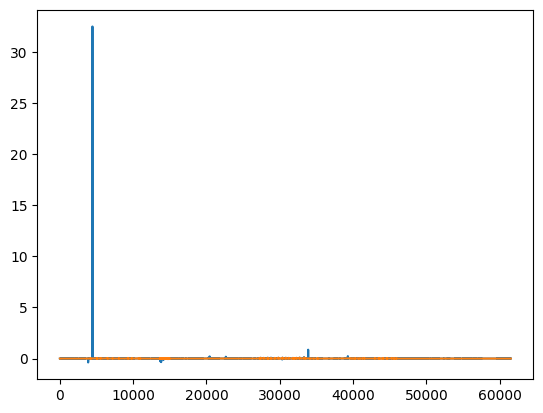

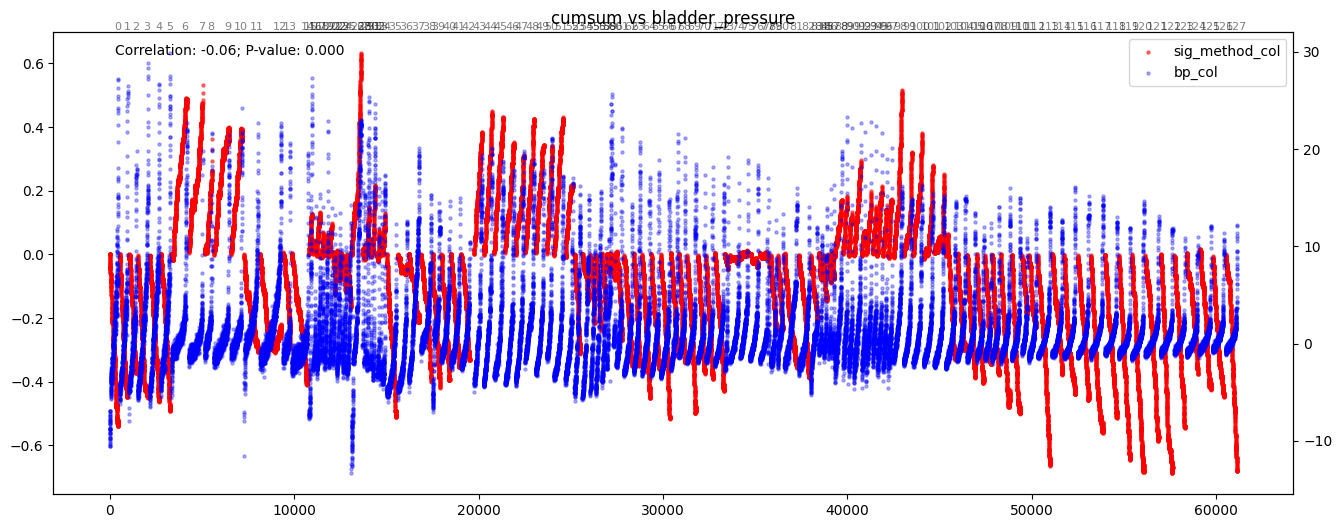

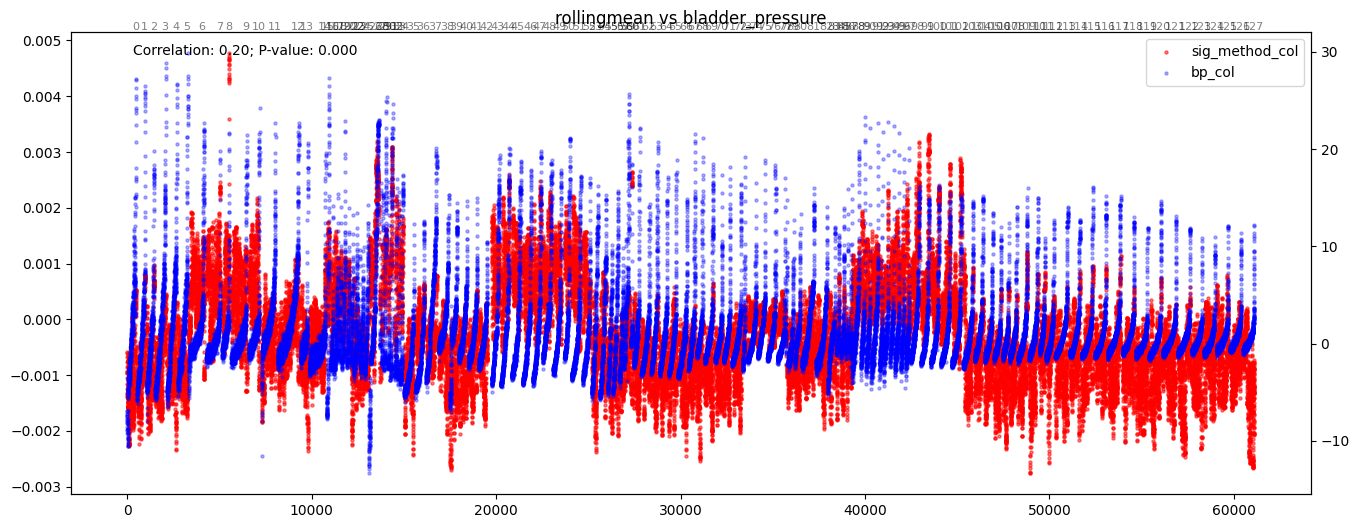

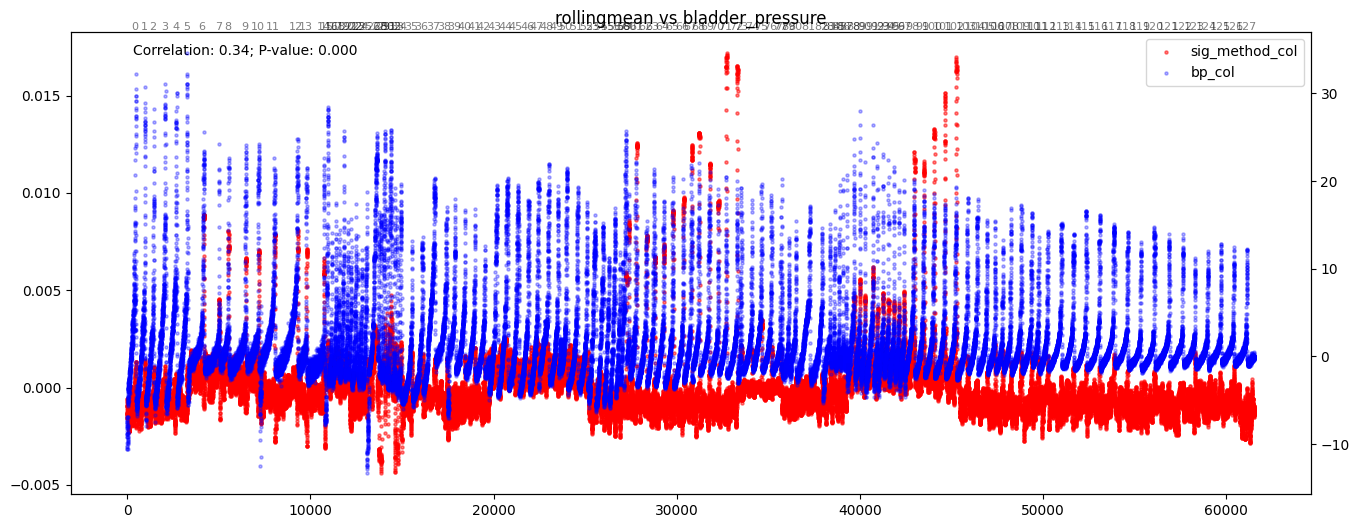

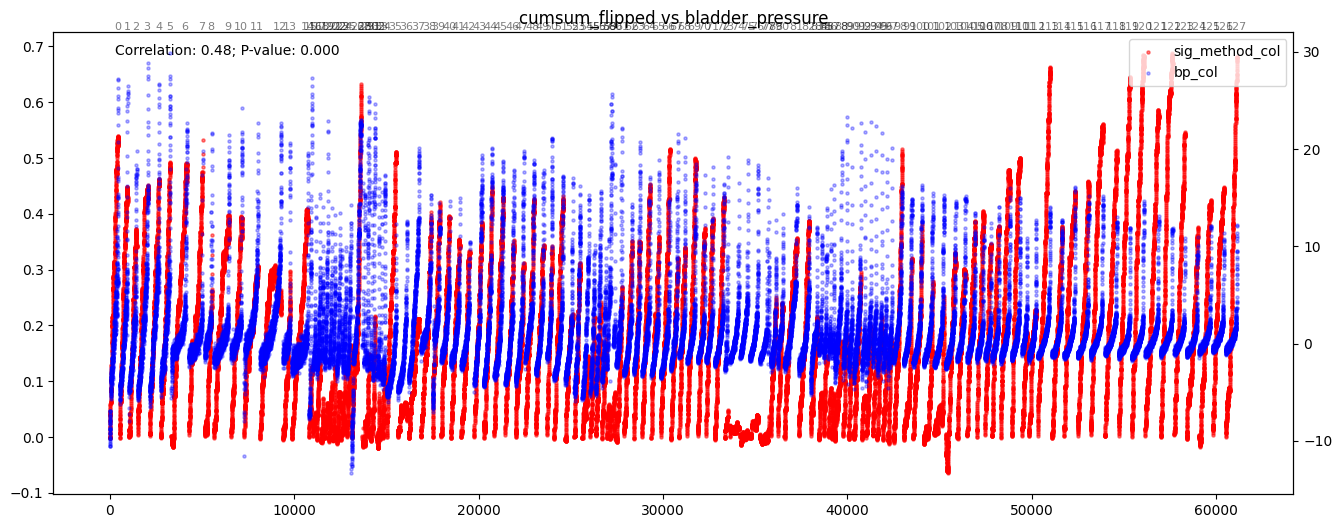

In [42]:
df_void, df_cumsum_void, cumsum_all_void, \
    df_rollingmean_void_void, rollingmean_all_void, df_rollingmean_source_void, df_rollingmean_source_all_void, \
        df_cumsum_flipped_void, cumsum_flipped_all_void = run_james_method(df_void.copy(), NEURAL_SIGNAL, BP_SIGNAL, void_or_bl='void')


print()
print('Mean Corr: ', f"{df_cumsum_flipped_void['Correlation'].mean():0.2}")
print('Median Corr: ', f"{df_cumsum_flipped_void['Correlation'].median():0.2}")
print('Max Corr: ', f"{df_cumsum_flipped_void['Correlation'].max():0.2}")
print('Min Corr: ', f"{df_cumsum_flipped_void['Correlation'].min():0.2}")
more_than_06 = (df_cumsum_flipped_void['Correlation']>0.6).sum()
total_number = len(df_cumsum_flipped_void)
print('r2 higher than 0.6: ', f'{more_than_06}/{total_number}', f'{more_than_06/total_number:0.2%}')

Mean Squared Error (MSE): 4.936062702510309
Root Mean Squared Error (RMSE): 2.221725163585791
Mean Absolute Error (MAE): 1.8394367924700283
R-squared: -0.755047007130967
Mean Squared Error (MSE): 7.39605477966755
Root Mean Squared Error (RMSE): 2.7195688591516762
Mean Absolute Error (MAE): 1.8816535582526774
R-squared: -1.6297120980717743
Mean Squared Error (MSE): 8.003467551727145
Root Mean Squared Error (RMSE): 2.829040040672303
Mean Absolute Error (MAE): 2.1439166792980147
R-squared: -1.8456813901867557


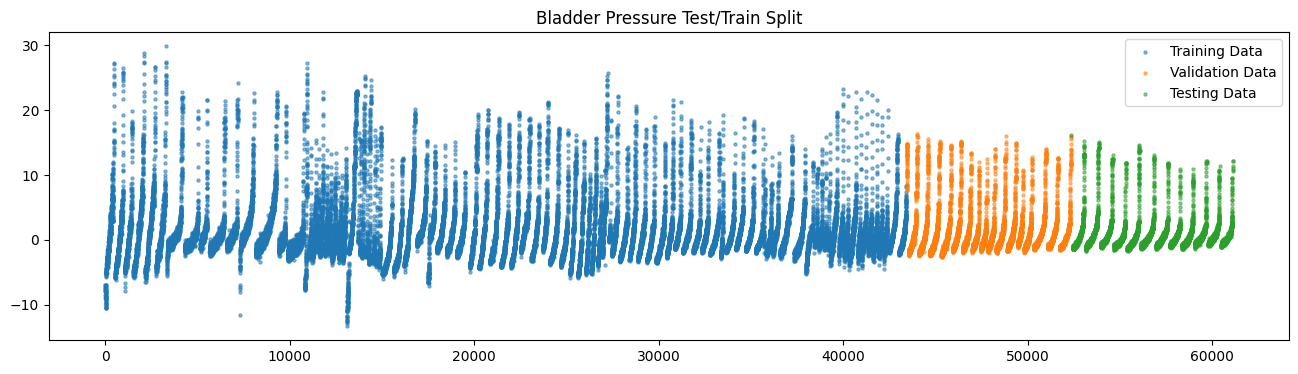

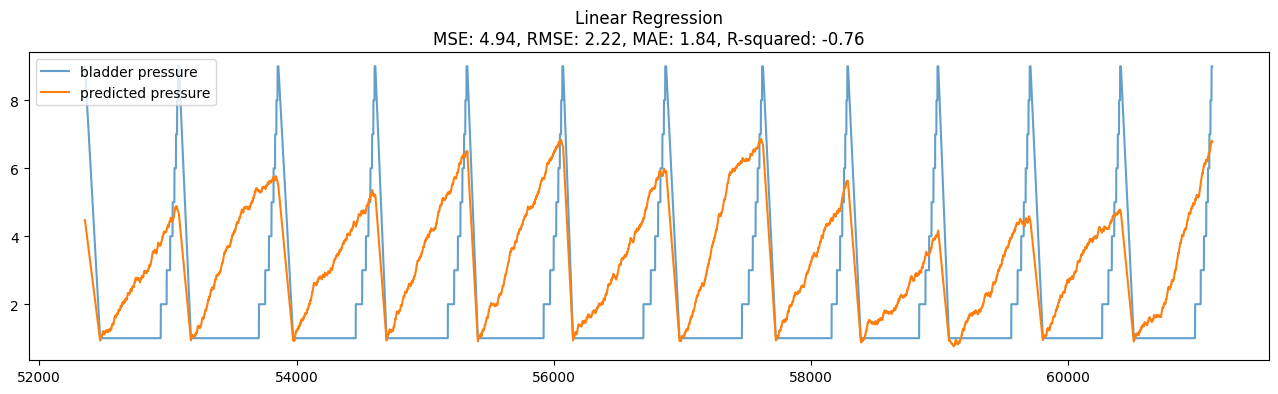

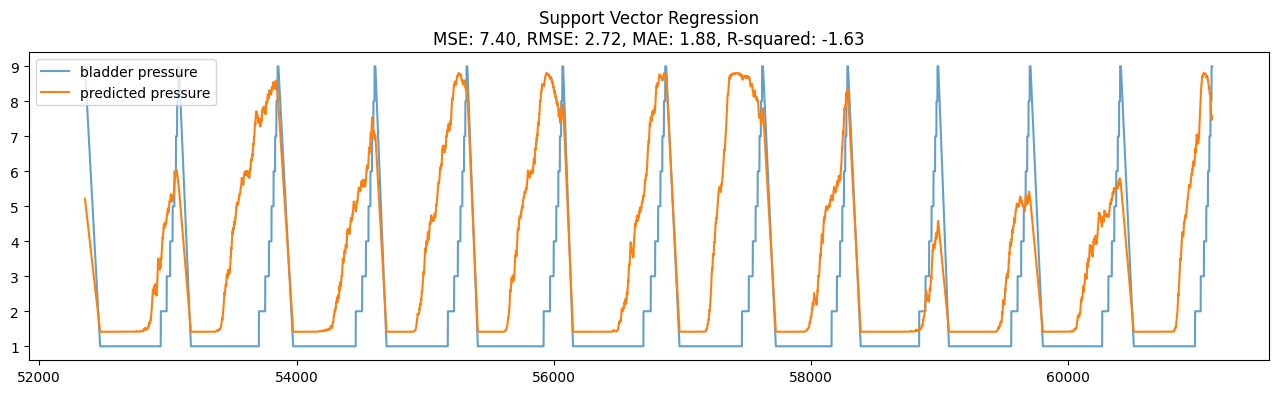

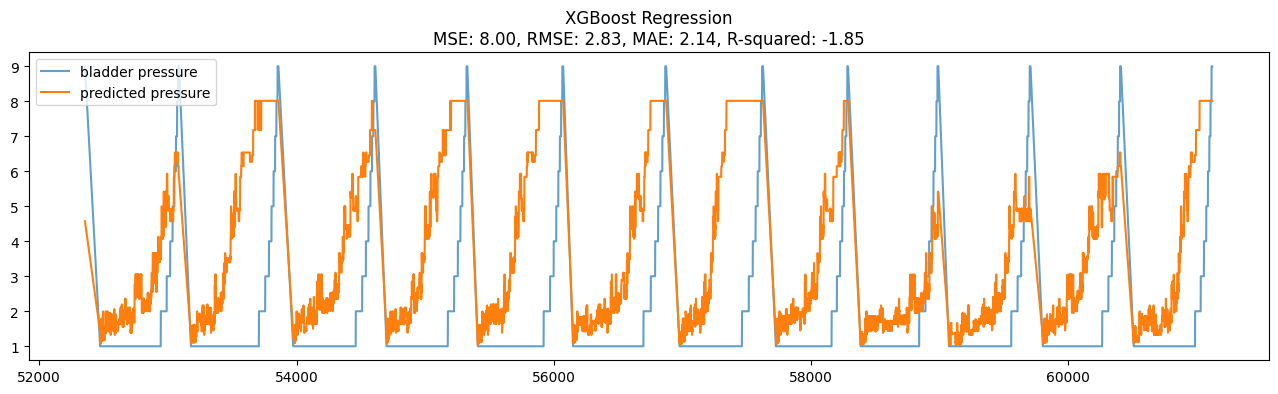

In [43]:
df_james = df_void[df_void['cumsum_flipped'].notna()]

cols_to_encode = ['']
X_cols_main = ['cumsum_flipped']
# y_cols_main = ['bladder_pressure']
y_cols_main = ['label_auto']

train_df, val_df, test_df, \
    X_cols, y_cols, \
    X_train, X_test, X_val, \
    y_train, y_test, y_val = encode_if_necessary_and_get_data_split(df_james, X_cols_main, cols_to_encode, y_cols_main,
                                                                    train_ratio=0.7, test_ratio_of_rest_of_data=0.5, 
                                                                    shuffle=False, show_plot=True)




In [ ]:
# =============================================================================
# Linear regression
# =============================================================================
mse_lr, rmse_lr, mae_lr, r2_lr, model_lr, model_type_lr = linear_regression(test_df, X_train, y_train, X_test, y_test, model_type = 'Linear Regression', print_output=True, show_plot=True)



In [ ]:

# =============================================================================
# SVR
# =============================================================================
mse_svr, rmse_svr, mae_svr, r2_svr, model_svr, model_type_svr = support_vector_regression(test_df, X_train, y_train, X_test, y_test, kernel='rbf', C=1.0, epsilon=0.2, model_type='Support Vector Regression', print_output=True, show_plot=True)



In [ ]:
# =============================================================================
# XGboost 
# =============================================================================
mse_xgbr, rmse_xgbr, mae_xgbr, r2_xgbr, model_xgbr, model_type_xgbr = xgboost_regression(test_df, X_train, y_train, X_test, y_test, objective='reg:squarederror', n_estimators=1000, learning_rate=0.1, max_depth=3, model_type='XGBoost Regression', print_output=True, show_plot=True)


In [47]:
df = df_void[df_void['cumsum_flipped'].notna()]

bladder_pressure vs cumsum_flipped: The Rho is 0.483 and p=0.0


/var/tmp/ipykernel_5498/3572829986.py:74: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


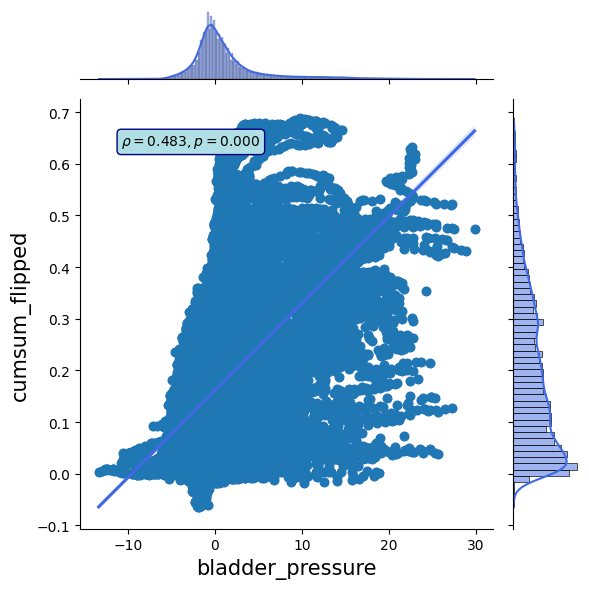

In [49]:
dv = 'bladder_pressure'
# ivs = [i for i in df.columns if dv not in i]
ivs = ['cumsum_flipped']

# =============================================================================
# Outlier removal
# =============================================================================
# removing outlier for all the data, but you can set it to just remove for dv
# models can be sensitive to extreme outliers

## remove outlier (affects model accuracy)

# logged_box_plot(df, 'Before outlier removal')
# df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
# logged_box_plot(df, 'After outlier removal')



# =============================================================================
# Simple linear regression (visualisation purposes)
# =============================================================================
## can be useful for understanding the shape of the data
## usually with many features, all features are unlikely to have linear relationship
get_corr(df, dv, ivs)

In [52]:
# =============================================================================
# Check for (multi)collinearity
# =============================================================================
# heatmap
# plt.figure(figsize=(7, 6))
# mask = np.triu(np.ones_like(df.corr(), dtype=bool))
# relation = df.corr()
# relation_index = relation.index
# sns.heatmap(df[relation_index].corr(), annot=True, mask=mask, vmin=-1, vmax=1)
# plt.title('Cross-correlation')
# plt.tight_layout()

# # seems acceptable..
# considered_features = ivs.copy()
# compute_vif(considered_features).sort_values('VIF', ascending=False)


In [75]:
# =============================================================================
# Model selection
# =============================================================================

# polynomial is a bit special and need to pipe it through first
# degree=2
# polyreg = make_pipeline(PolynomialFeatures(degree),LinearRegression())
polyreg_degree_2 = make_pipeline(PolynomialFeatures(2),LinearRegression())
polyreg_degree_3 = make_pipeline(PolynomialFeatures(3),LinearRegression())
polyreg_degree_4 = make_pipeline(PolynomialFeatures(4),LinearRegression())


# you can 'uncomment' these and test it out. They run pretty quickly.

regressors = {
    "XGBRegressor": XGBRegressor(),
    # "RandomForestRegressor": RandomForestRegressor(), # not great and takes a bit
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "LinearRegression": LinearRegression(),
    "RANSAC": RANSACRegressor(),
    "LASSO": Lasso(),
    # "Polynomial": polyreg,
    
    # "GaussianProcessRegressor": GaussianProcesssRegressor(), ## somehow it keeps crashing
    # "SVR": SVR(), # takes long
    # "NuSVR": NuSVR(), # takes long
    "LinearSVR": LinearSVR(),
    # "KernelRidge": KernelRidge(), # takes way too long
    "Ridge":Ridge(),
    # "TheilSenRegressor": TheilSenRegressor(), # takes tad bit longer
    "HuberRegressor": HuberRegressor(),
    "PassiveAggressiveRegressor": PassiveAggressiveRegressor(),
    "ARDRegression": ARDRegression(),
    "BayesianRidge": BayesianRidge(),
    "ElasticNet": ElasticNet(),

    "Polynomial_2": polyreg_degree_2,
    "Polynomial_3": polyreg_degree_3,
    "Polynomial_4": polyreg_degree_4,

}


NameError: name 'GaussianProcesssRegressor' is not defined

Feature - cumsum_flipped: 0.379291


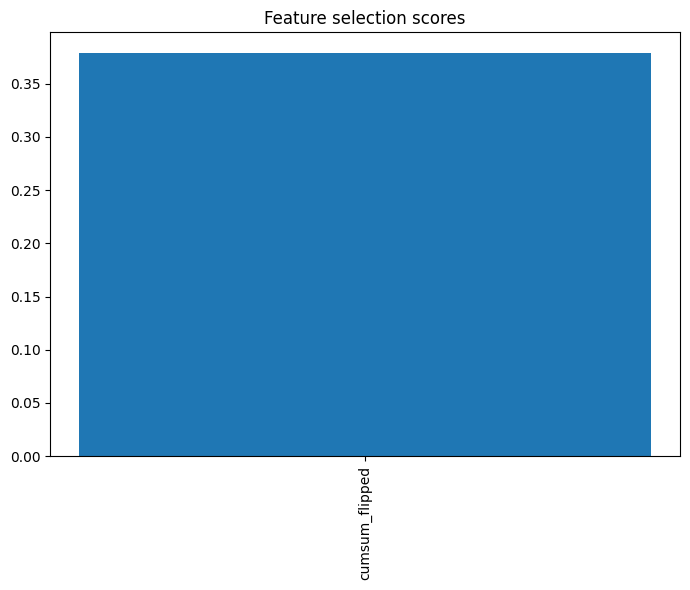

[''] do(es) not exist.


In [53]:


# =============================================================================
# Feature selection - using mutual info regression
# =============================================================================
X = df[ivs]
y = df[dv]

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

# X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test, f_regression)
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test, mutual_info_regression)

# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature - %s: %f' % (X.columns[i], fs.scores_[i]))
# plot the scores
plt.figure(figsize=(7, 6))
plt.bar(X.columns, fs.scores_)
plt.xticks(rotation=90)
plt.title('Feature selection scores')
plt.tight_layout()
plt.show()


# =============================================================================
# dropping column(s) / feature(s)
# =============================================================================
feature_to_be_removed = ['']

dv = 'bladder_pressure'
try:
    ivs.remove(feature_to_be_removed)
except:
    print(feature_to_be_removed, 'do(es) not exist.')    
    


# =============================================================================
# Split data - training / test
# =============================================================================
X = df[ivs]
y = df[dv].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=SEED)

train_index = X_train.index
test_index = X_test.index

# =============================================================================
# Scaling - mainly because we are comparing different models below
# but also, the range are quite different. I think for RF, it may not be
# necessary, but I like scaling. Will leave this up to you.
# =============================================================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



* XGBRegressor
* RandomForestRegressor
* DecisionTreeRegressor
* LinearRegression
* RANSAC
* LASSO
* LinearSVR


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: Futu

* Ridge
* TheilSenRegressor
* HuberRegressor
* PassiveAggressiveRegressor
* ARDRegression
* BayesianRidge
* ElasticNet
* Polynomial_2
* Polynomial_3
* Polynomial_4
                         model run_time  r-squared    mae   rmse  rmse_cv  \
14                Polynomial_2    0.003     -1.723  3.231  4.852    3.735   
15                Polynomial_3    0.002     -2.943  3.585  5.839    3.753   
16                Polynomial_4    0.003     -2.805  3.555  5.736    3.759   
12               BayesianRidge    0.002     -0.593  2.834  3.711    3.803   
3             LinearRegression    0.001     -0.593  2.834  3.711    3.803   
11               ARDRegression    0.002     -0.593  2.834  3.711    3.803   
7                        Ridge    0.001     -0.593  2.834  3.711    3.803   
0                 XGBRegressor    0.044     -1.633  3.207  4.772    3.835   
5                        LASSO    0.001      0.028  2.294  2.899    3.919   
9               HuberRegressor    0.005      0.048  2.036  2.869  

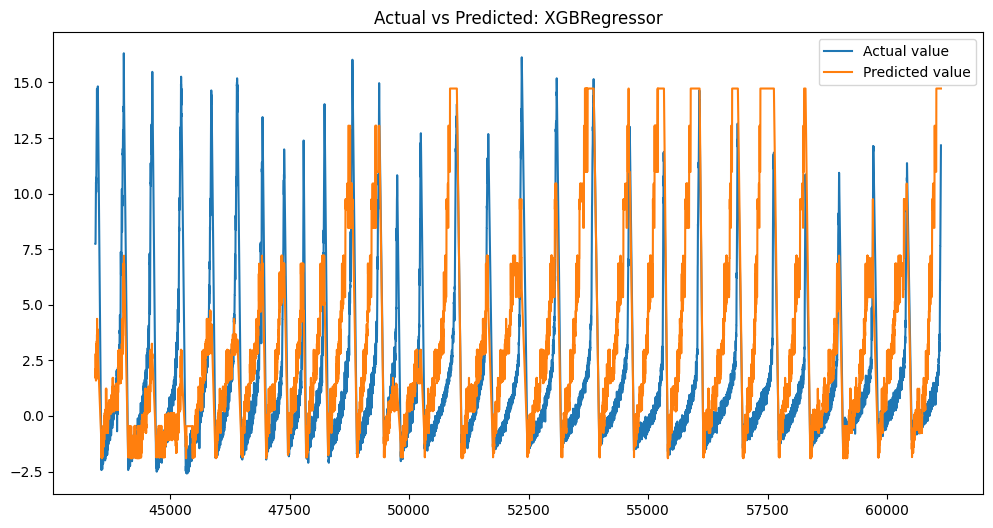

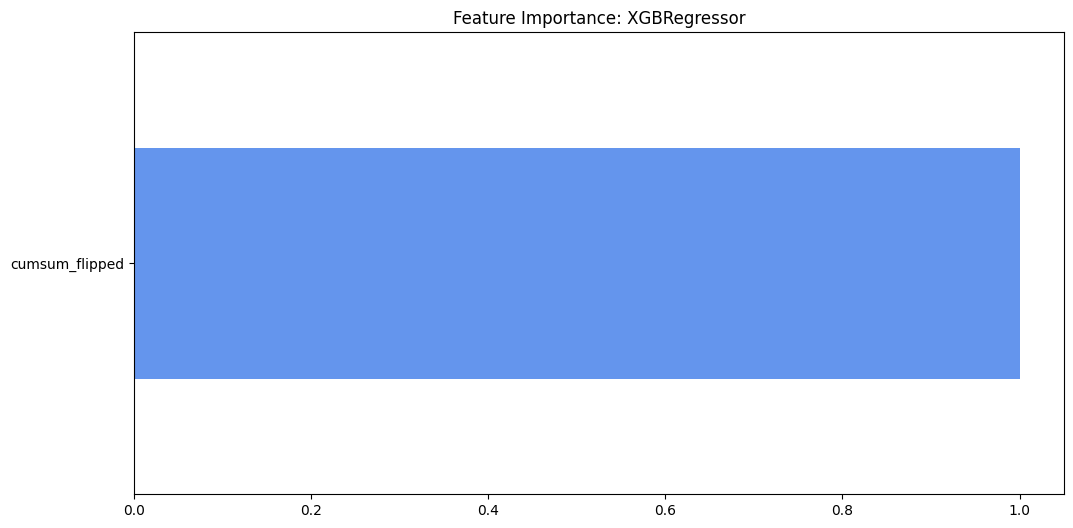

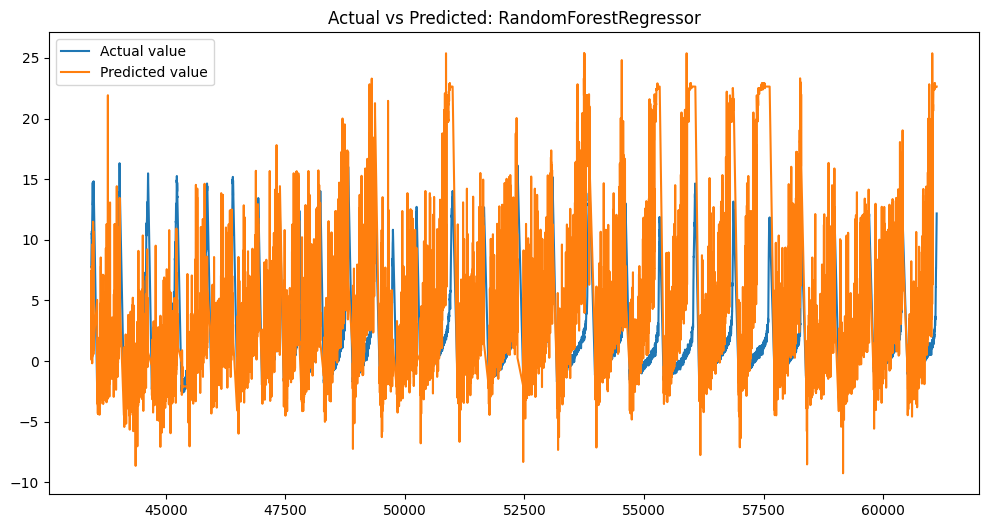

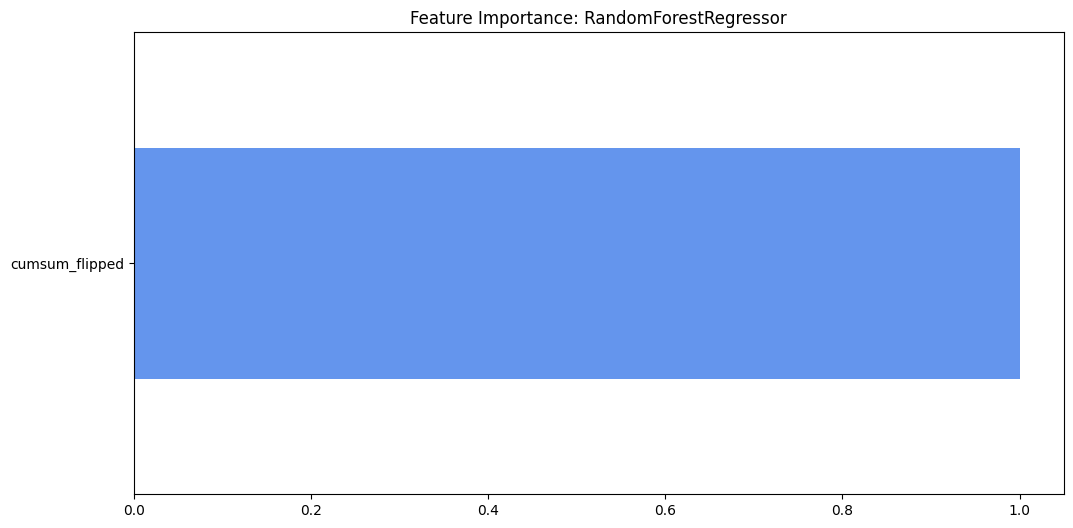

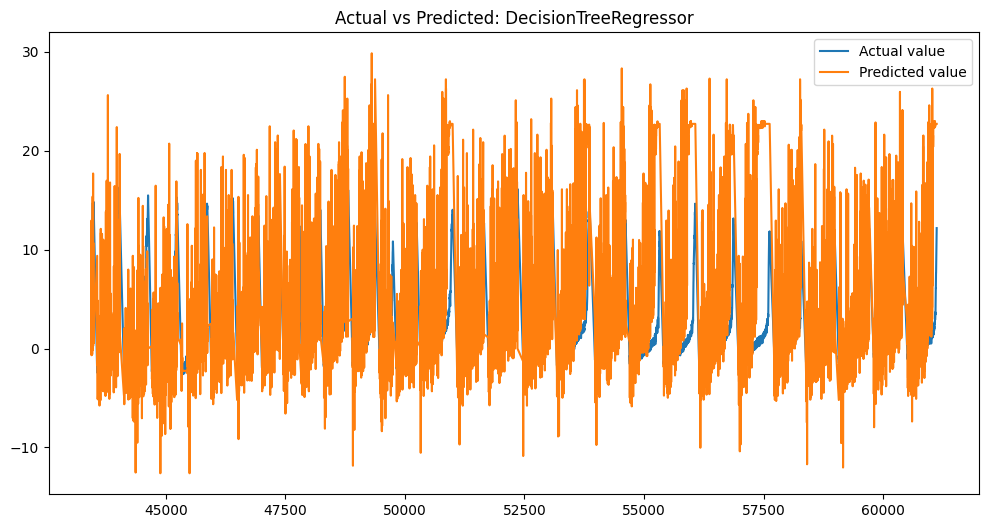

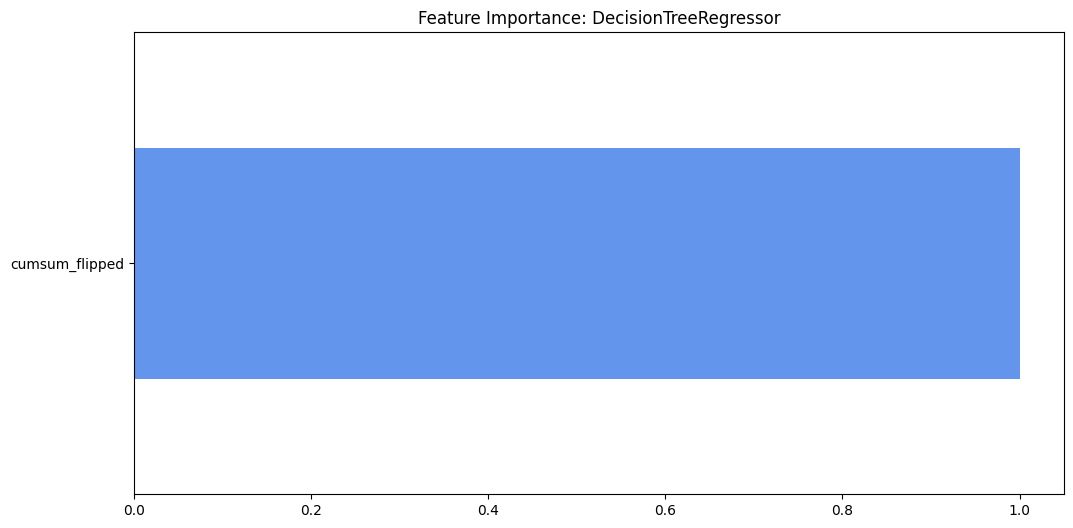

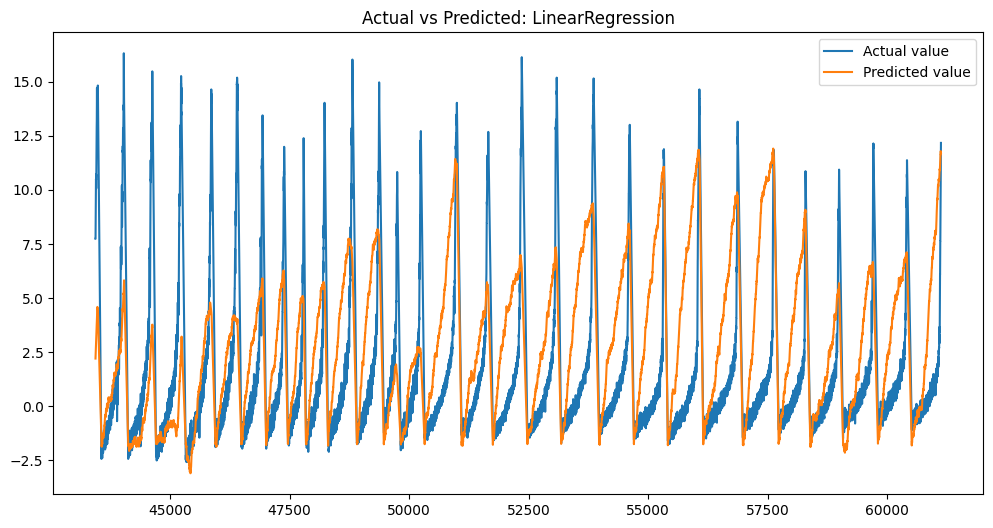

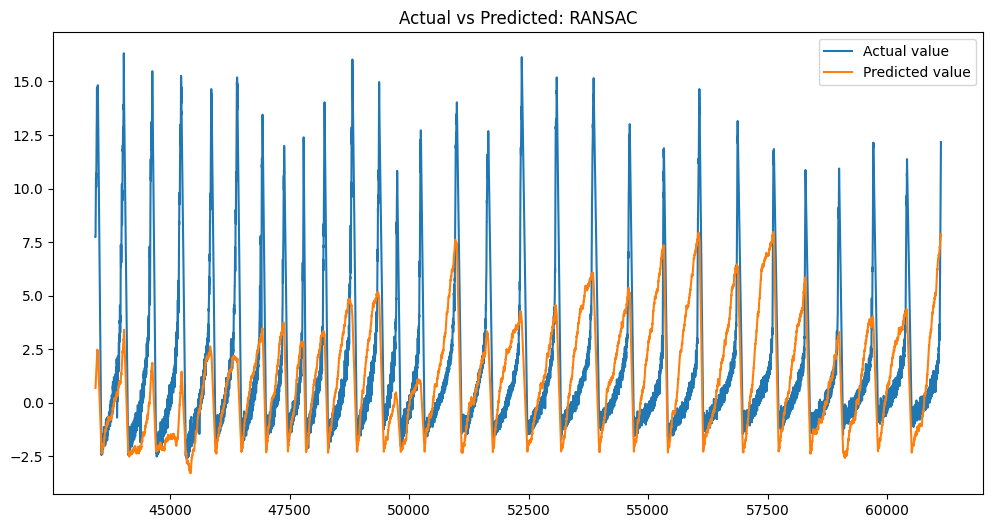

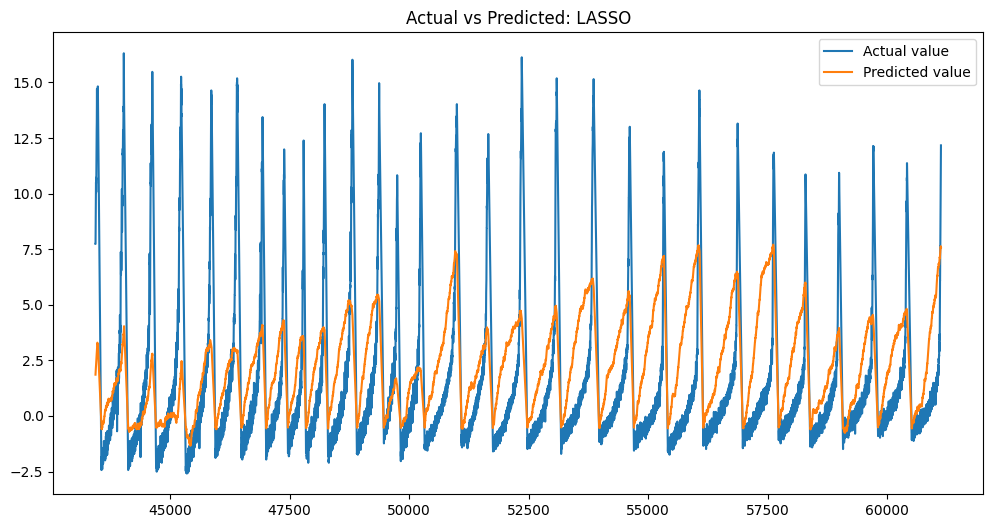

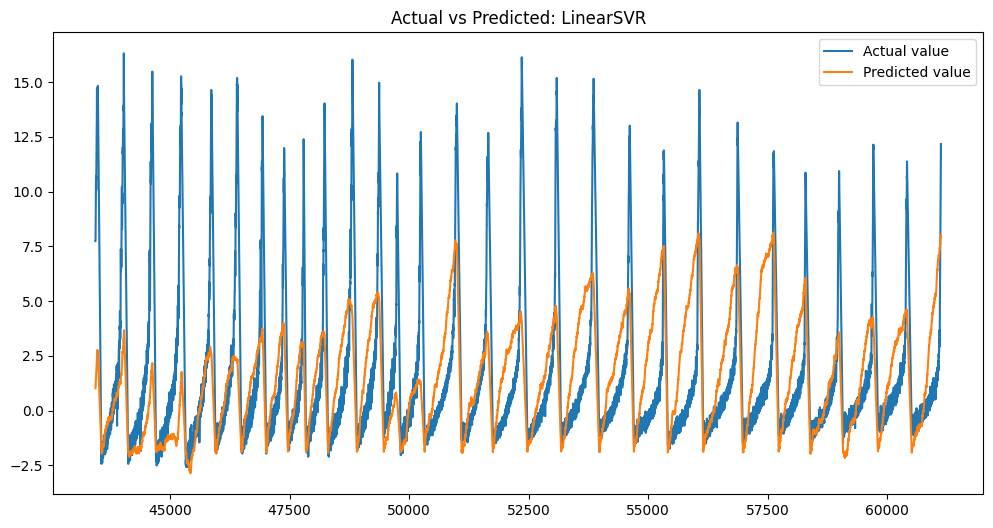

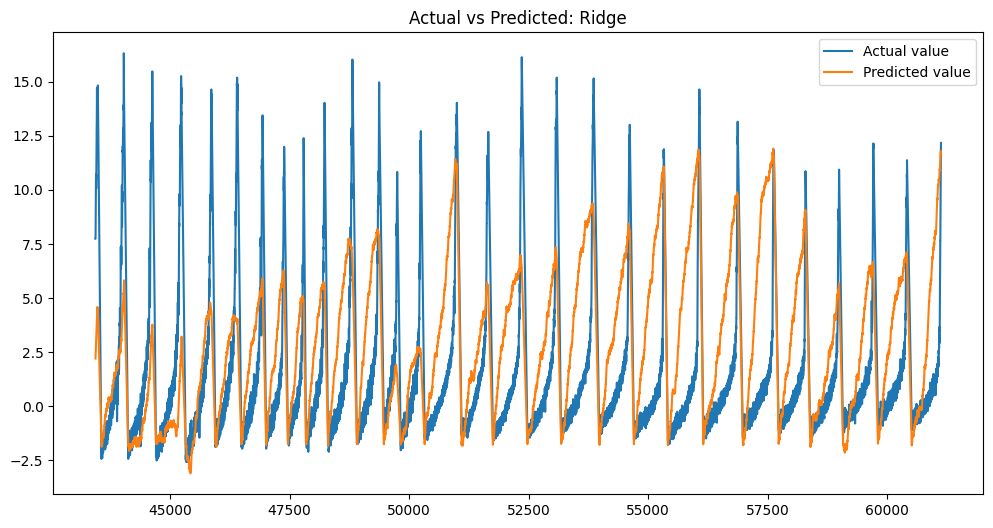

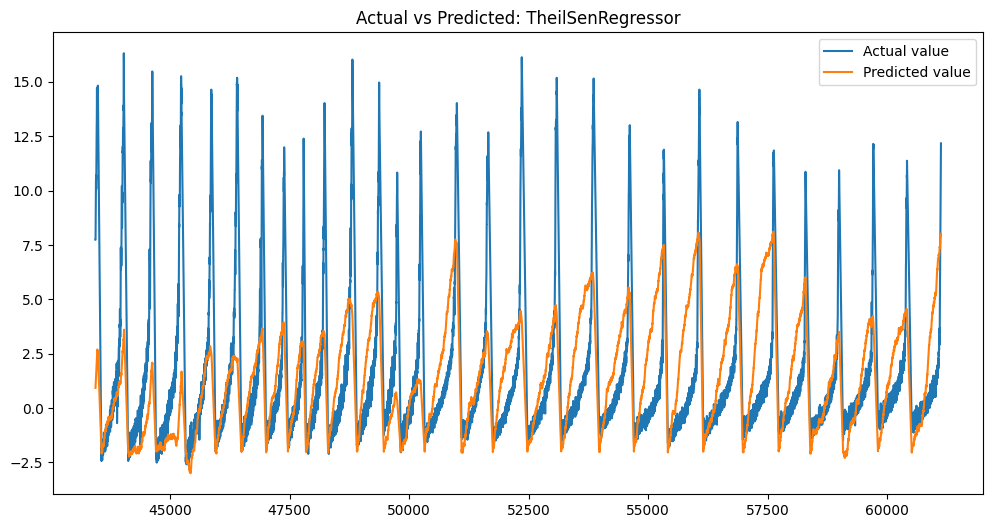

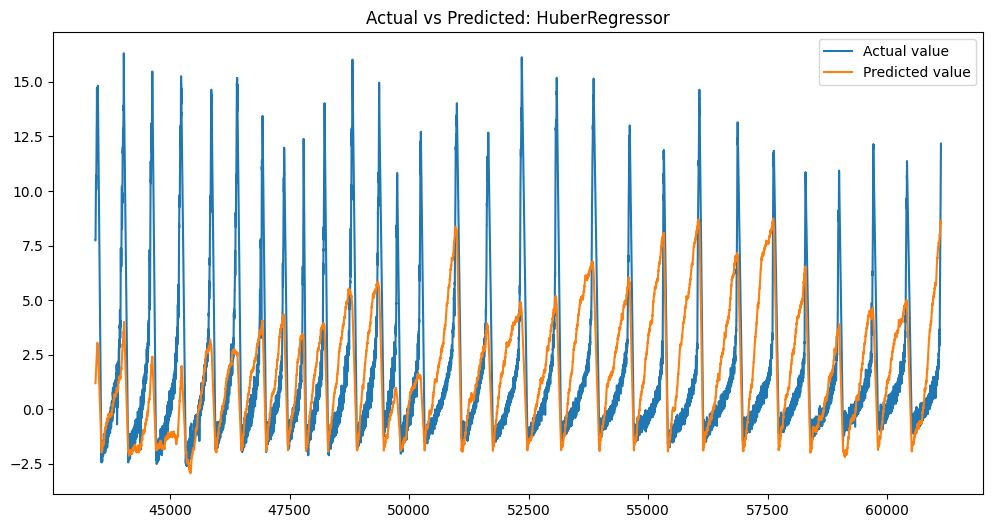

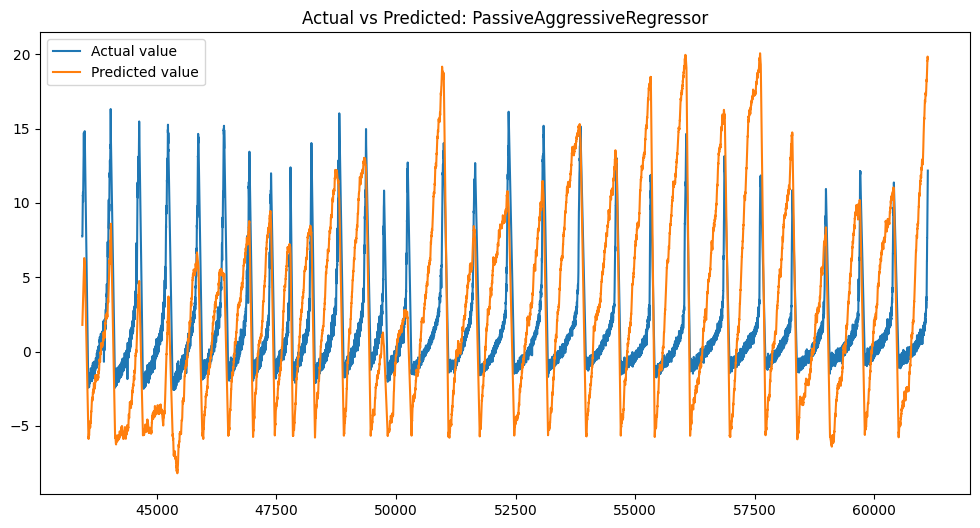

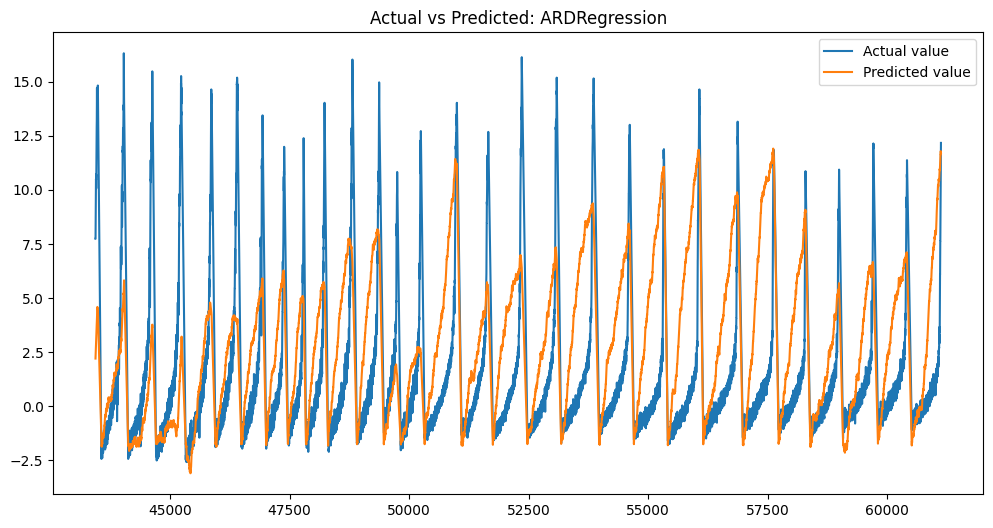

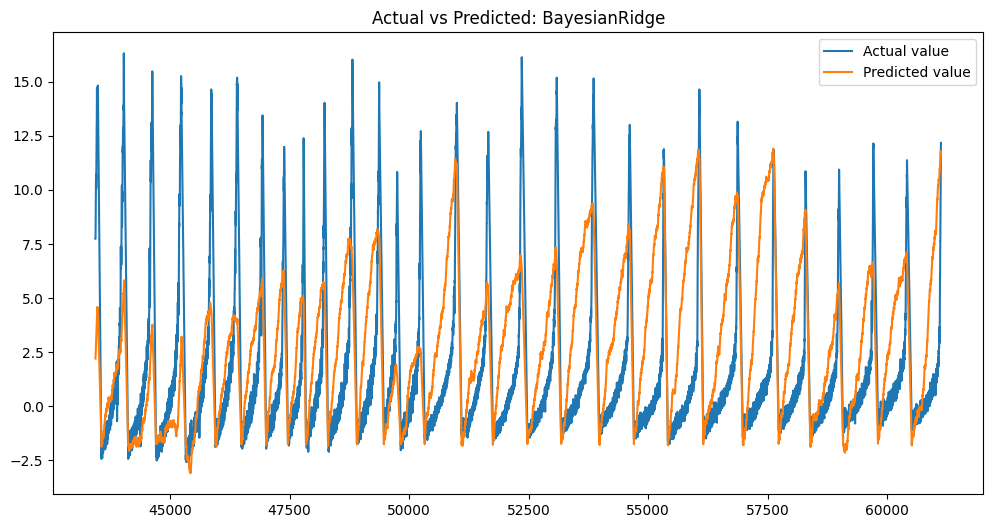

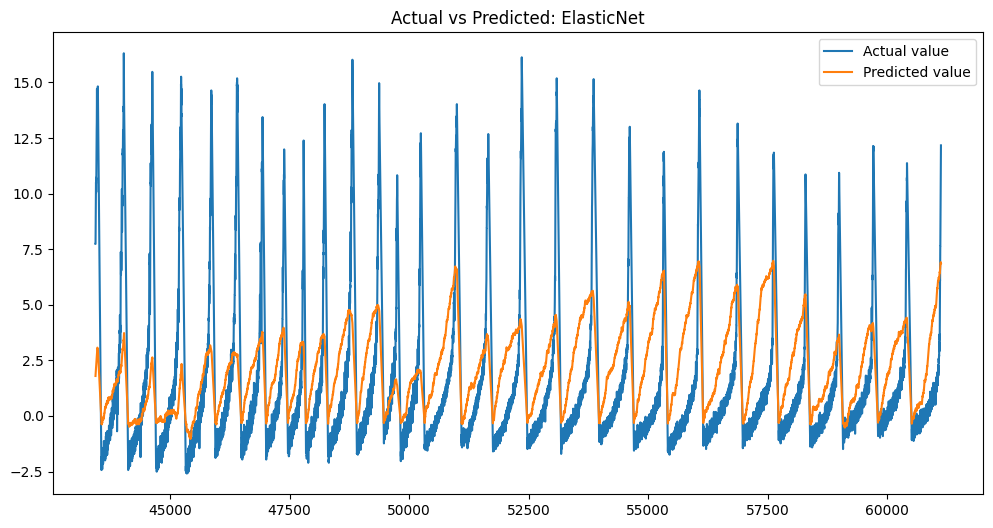

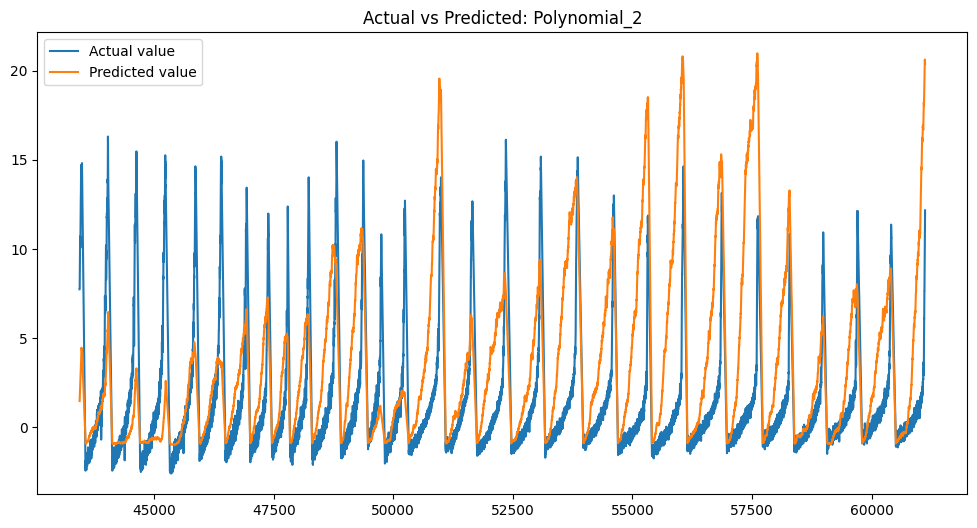

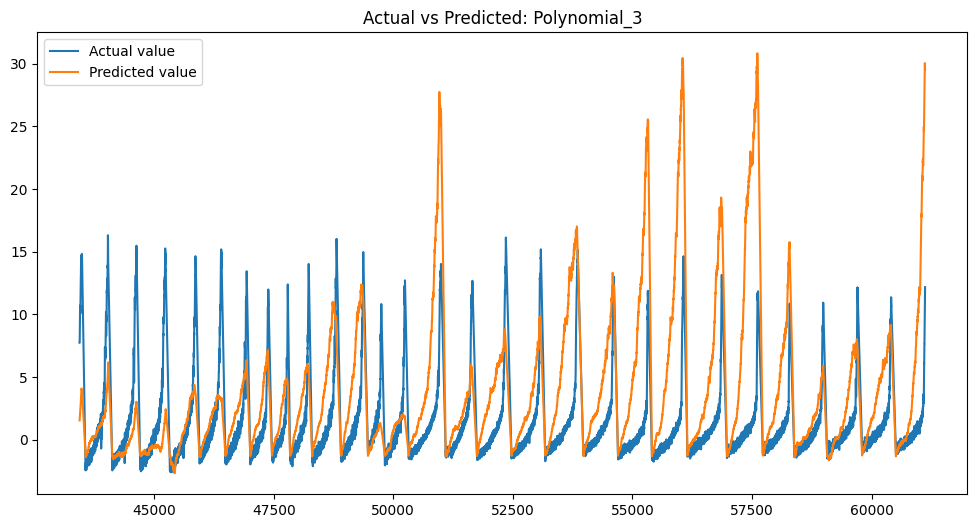

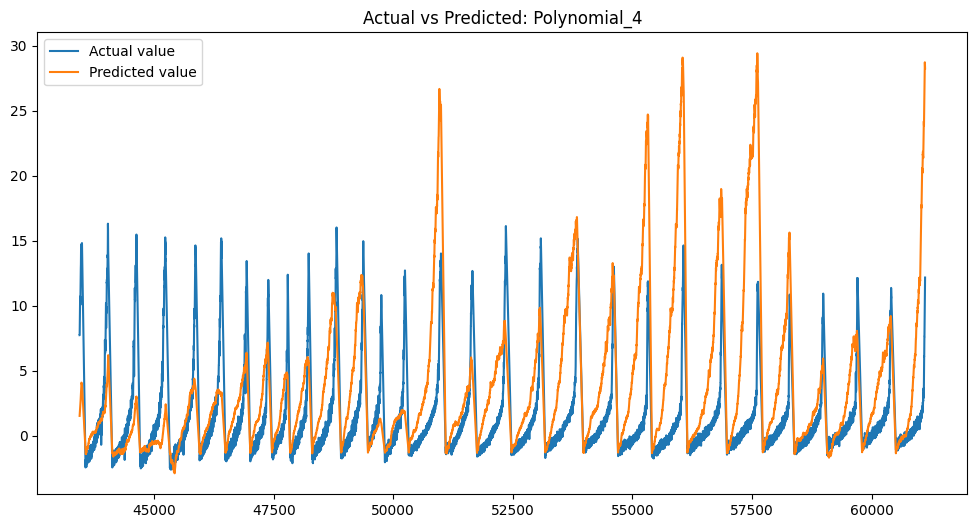

In [59]:
# =============================================================================
# loop and ranking based on rmse_cv (10-fold cross-validation)
# =============================================================================

df_models = pd.DataFrame(columns=['model', 'run_time', 'r-squared', 'mae', 'rmse', 'rmse_cv'])

for key in regressors:

    print('*',key)

    start_time = time.time()
    
    regressor = regressors[key]
    model = regressor.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # plot check
    plot_actual_vs_predicted_value(test_index, y_pred, y_test, f'Actual vs Predicted: {key}')    
    
    if key in ['XGBRegressor','RandomForestRegressor','DecisionTreeRegressor']:
        plot_feature_importance(regressor, key)

    scores = cross_val_score(model, 
                             X_train, 
                             y_train,
                             scoring="neg_mean_squared_error", 
                             cv=10)
    
    _r2_score, _mae, _mse, _rmse = eval_models(model, y_test, y_pred)

    row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60, 3)),
           'r-squared': round(_r2_score, 3),
           'mae': round(_mae, 3),
           'mse': round(_mse, 3),
           'rmse': round(_rmse, 3),
           'rmse_cv': round(np.mean(np.sqrt(-scores)), 3)
    }
    
    df_dict = pd.DataFrame([row])
    df_models = pd.concat([df_models, df_dict], ignore_index=True)


# see scoring
print(df_models.sort_values(by='rmse_cv', ascending=True))



R-squared: -1.633
Mean Absolute Error: 3.207
Mean Squared Error: 22.767
Root Mean Squared Error: 4.772


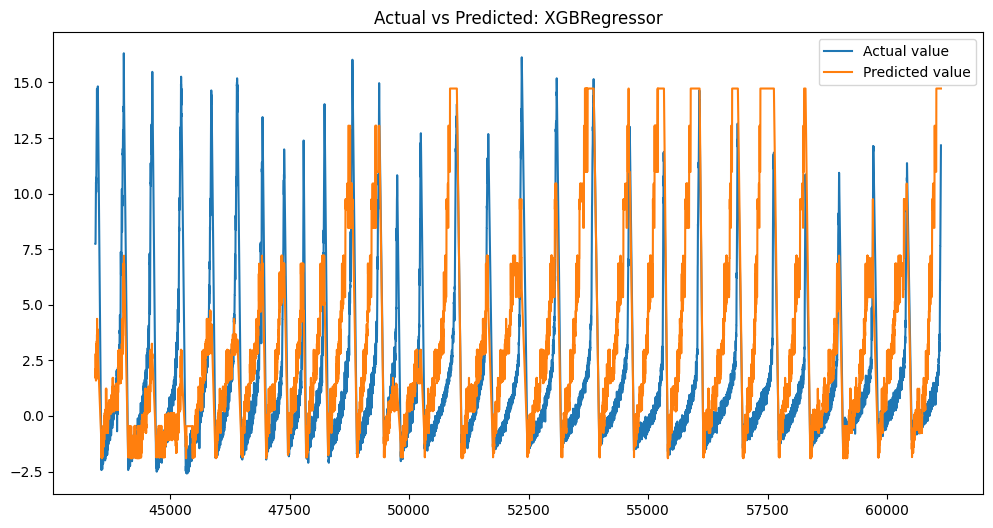

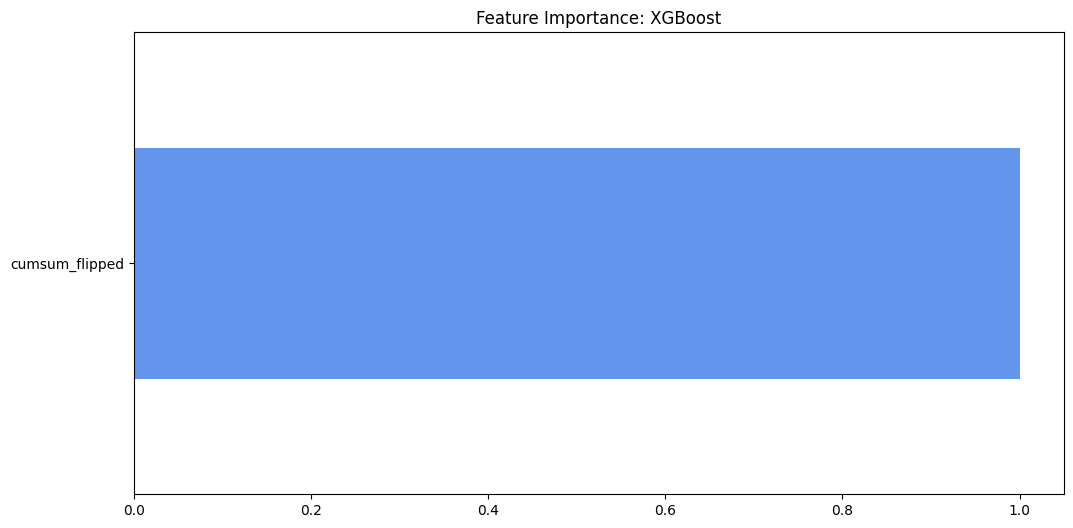

In [63]:
# =============================================================================
# plot (picking XGB for now)
# =============================================================================
regressor = XGBRegressor(random_state=SEED)
model = regressor.fit(X_train, y_train)
y_pred = model.predict(X_test)

eval_models(model, y_test, y_pred, True)
plot_actual_vs_predicted_value(test_index, y_pred, y_test, 'Actual vs Predicted: XGBRegressor')    
plot_feature_importance(regressor, 'XGBoost')




In [64]:
RF_HYPERPARAM_TUNING = True

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Optimum parameters:
{'colsample_bytree': 0.6,
 'gamma': 0.3,
 'learning_rate': 0.01,
 'max_depth': 1,
 'min_child_weight': 3,
 'n_estimators': 410,
 'reg_alpha': 0.1,
 'subsample': 0.7}
Mean Squared Error: 15.45751642660561
R-squared: -0.7878313653272344
R-squared: -0.788
Mean Absolute Error: 2.789
Mean Squared Error: 15.458
Root Mean Squared Error: 3.932


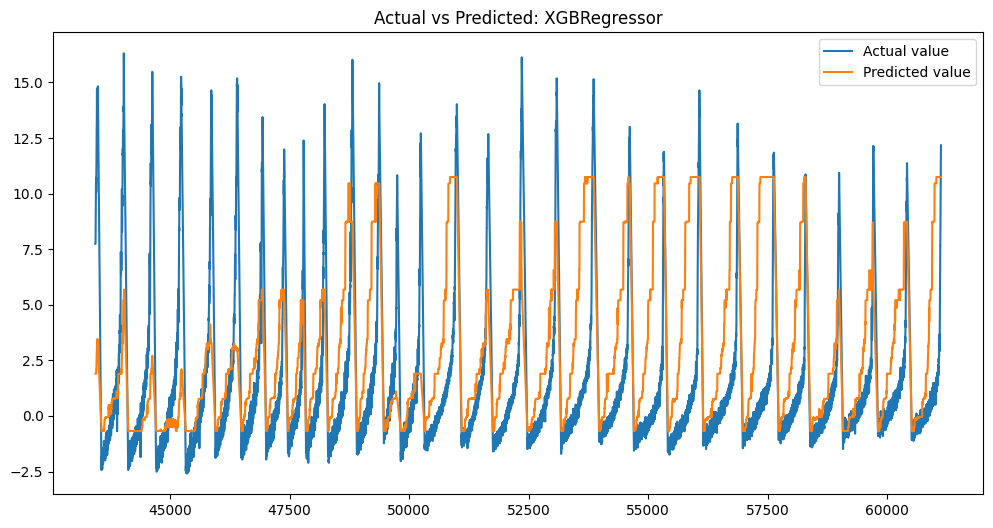

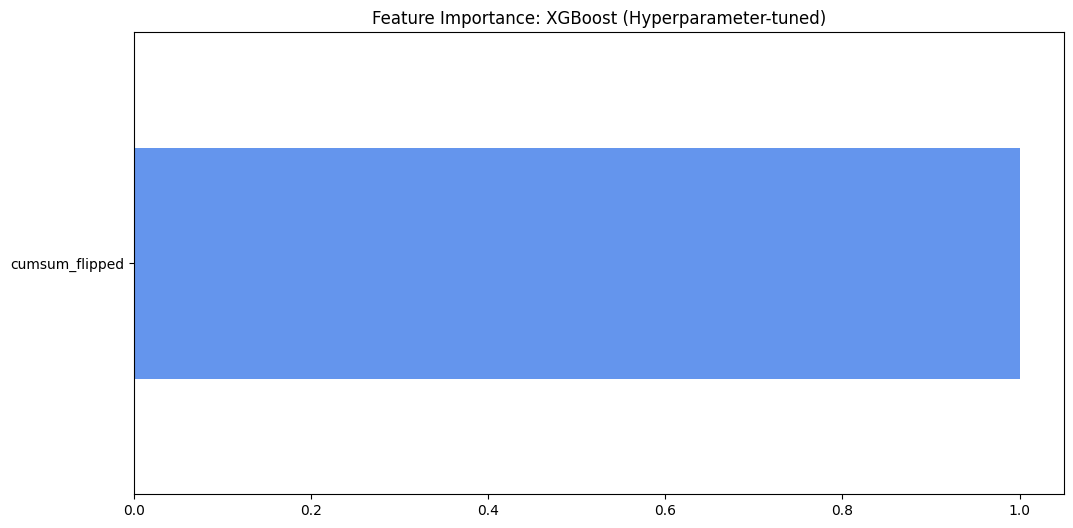

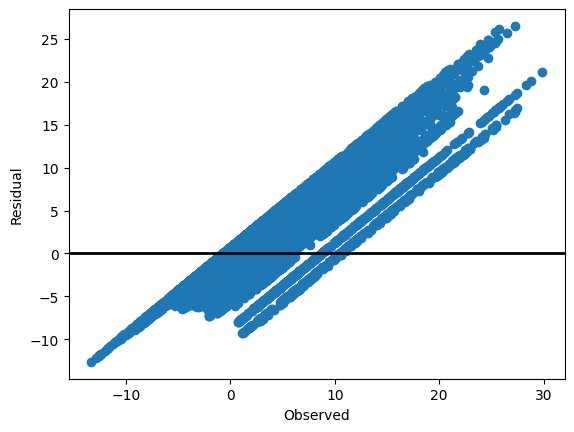

KeyError: "['param_max_leaf_nodes'] not in index"

[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=1, min_child_weight=4, n_estimators=350, reg_alpha=0, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.3, max_depth=17, min_child_weight=5, n_estimators=250, reg_alpha=1.0, subsample=0.9; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.2, max_depth=15, min_child_weight=2, n_estimators=290, reg_alpha=0.01, subsample=0.6; total time=   1.8s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=13, min_child_weight=2, n_estimators=280, reg_alpha=1.0, subsample=0.9; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=1, min_child_weight=5, n_estimators=10, reg_alpha=1.0, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=13, min_child_weight=1, n_estimators=410, reg_alpha=0.01, subsample=0.7; total time=   2.0s
[CV] END colsample_bytree=0.6, g

In [66]:
if RF_HYPERPARAM_TUNING:
    # =============================================================================
    # Hyperparameter tuning -- THIS TAKES VERY LONG
    # Try out whatever you think is best
    # =============================================================================
    model.get_params()
    
    def eval_best_xgb_model(best_model, X_test, y_test):
        y_pred = best_model.predict(X_test)        
        eval_models(best_model, y_test, y_pred, True)
        plot_actual_vs_predicted_value(test_index, y_pred, y_test, 'Actual vs Predicted: XGBRegressor')    
        plot_feature_importance(best_model.best_estimator_, 'XGBoost (Hyperparameter-tuned)')
        
       
        predicted = best_model.best_estimator_.predict(X_train)
        residuals = y_train-predicted
        
        fig, ax = plt.subplots()
        ax.scatter(y_train, residuals)
        ax.axhline(lw=2,color='black')
        ax.set_xlabel('Observed')
        ax.set_ylabel('Residual')
        plt.show()
    
    # =============================================================================
    #     # random search -- quick
    # =============================================================================
    random_grid = {
        'n_estimators': [int(x) for x in np.linspace(start=10, stop=500, num=50)],
        'max_depth': [int(x) for x in np.linspace(1, 20, num=10)],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
        'min_child_weight': [1, 2, 3, 4, 5],
        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'reg_alpha': [0, 0.001, 0.01, 0.1, 1.0]
    }
    
    xgb = XGBRegressor(random_state=SEED)
    xgb_random = RandomizedSearchCV(estimator = xgb, 
                                   param_distributions = random_grid, 
                                   n_iter = 200, 
                                   cv = 3, 
                                   verbose = 2, 
                                   random_state = SEED, 
                                   n_jobs = -1)
    
    best_model_xgb = xgb_random.fit(X_train, y_train)   
    print('Optimum parameters:')
    pprint(best_model_xgb.best_params_)
    
    eval_best_xgb_model(best_model_xgb, X_test, y_test)



In [73]:
df_gs = pd.DataFrame(data=best_model_xgb.cv_results_)
fig,ax = plt.subplots()
sns.pointplot(data=df_gs_plot,
              y='mean_test_score',
              x='param_max_depth',
              hue='param_max_leaf_nodes',
              ax=ax)
ax.set(title="Effect of Depth and Leaf Nodes on Model Performance")


In [74]:
df_gs

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         2.399961      0.061956         0.626715        0.057604   
1         0.330387      0.025509         0.029342        0.000256   
2         1.192549      0.048414         0.380498        0.040797   
3         0.451012      0.005510         0.082534        0.000167   
4         0.565909      0.037732         0.096697        0.007543   
..             ...           ...              ...             ...   
195       0.334846      0.007787         0.032398        0.000391   
196       0.587401      0.004856         0.106522        0.002880   
197       1.046823      0.108268         0.244848        0.006231   
198       1.084147      0.067435         0.169154        0.005678   
199       1.191202      0.092386         0.316345        0.006009   

    param_subsample param_reg_alpha param_n_estimators param_min_child_weight  \
0               0.6           0.001                460                      1   
1               0.6               0                350                      4   
2               0.8           0.001                430                      3   
3               0.9               0                420                      5   
4               1.0             0.1                120                      1   
..              ...             ...                ...                    ...   
195             0.7             0.1                410                      3   
196             0.8               0                130                      4   
197             0.7               0                390                      1   
198             1.0             1.0                400                      1   
199             0.6            0.01                400                      5   

    param_max_depth param_learning_rate param_gamma param_colsample_bytree  \
0                17                0.01         0.3                    0.7   
1                 1                0.01         0.1                    0.9   
2                 9                 0.3         0.4                    0.8   
3                 3                 0.1         0.2                    1.0   
4                15               0.001         0.3                    1.0   
..              ...                 ...         ...                    ...   
195               1                0.01         0.3                    0.6   
196              20               0.001         0.2                    0.9   
197              11                 0.1         0.3                    0.7   
198               9               0.001         0.2                    1.0   
199              13                 0.3         0.1                    1.0   

                                                params  split0_test_score  \
0    {'subsample': 0.6, 'reg_alpha': 0.001, 'n_esti...           0.254499   
1    {'subsample': 0.6, 'reg_alpha': 0, 'n_estimato...           0.272924   
2    {'subsample': 0.8, 'reg_alpha': 0.001, 'n_esti...           0.251507   
3    {'subsample': 0.9, 'reg_alpha': 0, 'n_estimato...           0.254052   
4    {'subsample': 1.0, 'reg_alpha': 0.1, 'n_estima...           0.073049   
..                                                 ...                ...   
195  {'subsample': 0.7, 'reg_alpha': 0.1, 'n_estima...           0.276994   
196  {'subsample': 0.8, 'reg_alpha': 0, 'n_estimato...           0.078531   
197  {'subsample': 0.7, 'reg_alpha': 0, 'n_estimato...           0.252503   
198  {'subsample': 1.0, 'reg_alpha': 1.0, 'n_estima...           0.182619   
199  {'subsample': 0.6, 'reg_alpha': 0.01, 'n_estim...           0.245028   

     split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0             0.225697           0.201010         0.227069        0.021858   
1             0.207686           0.293410         0.258007        0.036552   
2             0.225709           0.198360         0.225192        0.021700   
3             0.228978       